In [1]:
import pandas as pd
import numpy as np
import string
import keras
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Lambda, Input, Dense, Dropout, Flatten
from keras.layers import Input, LSTM, Embedding, Dense
from keras.layers.advanced_activations import LeakyReLU,ThresholdedReLU
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam,Nadam,Adamax
from string import digits
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import initializers
from tensorflow.keras.datasets import cifar10
%matplotlib inline

np.random.seed(100)

In [91]:
lines= pd.read_table("ukr.txt",  names =['source', 'target', 'comments'])

In [92]:
lines

,source,target,comments
0,Go.,Йди.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hi.,Вітаю!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Hi.,Привіт.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,Hi.,Привіт!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Run!,Біжіть!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
...,...,...,...
153805,If you take a child outside and point at the m...,Якщо вивести дитину на вулицю і показати їй на...,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
153806,"When writing a sentence, generally you start w...","При написанні речення, його зазвичай починають...",CC-BY 2.0 (France) Attribution: tatoeba.org #3...
153807,"If forests cover 9.4% of the earth's surface, ...","Якщо ліси складають 9,4% поверхні Землі, і якщ...",CC-BY 2.0 (France) Attribution: tatoeba.org #1...
153808,"The Tatoeba Project, which can be found online...","Проект ""Татоеба"", що знаходиться онлайн за адр...",CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [4]:
translator = re.compile('[%s]' % re.escape(string.punctuation))
lines['source'] = lines['source'].apply(lambda x: translator.sub(' ', x))
lines['target'] = lines['target'].apply(lambda x: translator.sub(' ', x))

In [93]:
lines.head()

,source,target,comments
0,Go.,Йди.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hi.,Вітаю!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Hi.,Привіт.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,Hi.,Привіт!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Run!,Біжіть!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [94]:
lines['source'] = lines['source'].str.lower()
lines['target'] = lines['target'].str.lower()

In [95]:
lines.head()

,source,target,comments
0,go.,йди.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,hi.,вітаю!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,hi.,привіт.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,hi.,привіт!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,run!,біжіть!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [96]:
lines["target"] = lines["target"].apply(lambda x : 'START_ '+ x + ' _END')

In [97]:
lines.head()

,source,target,comments
0,go.,START_ йди. _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,hi.,START_ вітаю! _END,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,hi.,START_ привіт. _END,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,hi.,START_ привіт! _END,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,run!,START_ біжіть! _END,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [98]:
num_digits= str.maketrans('','', digits)
lines["source"]=lines["source"].apply(lambda x: x.translate(num_digits))
lines["target"]=lines["target"].apply(lambda x: x.translate(num_digits))

In [99]:
all_source_words=set()
for source in lines["source"][:10000]:
    for word in source.split():
        if word not in all_source_words:
            all_source_words.add(word)

all_target_words=set()
for target in lines["target"][:10000]:
    for word in target.split():
        if word not in all_target_words:
            all_target_words.add(word)

source_words=sorted(list(all_source_words))
target_words=sorted(list(all_target_words))

In [100]:
all_source_words

{'unusual.',
 'cheered.',
 'house.',
 'true!',
 'open.',
 'bus.',
 'what?',
 'trapped.',
 'asked',
 'dances.',
 'dead.',
 'woman.',
 'cover!',
 'bipolar.',
 'guilty?',
 'lucky',
 'speed',
 'medic.',
 'heroic.',
 'simple.',
 'yell.',
 'reliable.',
 'optimist.',
 'fools.',
 'made',
 'wasted.',
 'catch',
 'meek.',
 'new',
 'good?',
 "what's",
 'prepaid.',
 'almost',
 'put.',
 'comes.',
 'elected.',
 'panting.',
 'is!',
 'furious.',
 "isn't",
 'all',
 'betrayed',
 'won?',
 'jock.',
 'tired',
 'dad',
 'unlikely.',
 'is',
 'shy',
 'please.',
 'stole',
 'close.',
 'say',
 'nailed',
 'raining?',
 'boil',
 'way.',
 'cheer',
 'way!',
 'patient.',
 'crashed.',
 'suicide.',
 'jaw',
 'bears',
 'lost?',
 'hesitant.',
 "tom's.",
 'mind?',
 'blogger.',
 'cold.',
 'tacky.',
 'budge.',
 'kid',
 'unkind.',
 'loves',
 'plans.',
 'ails',
 'hello',
 'go?',
 'there?',
 'immune.',
 'no',
 'even',
 'talk!',
 'objected.',
 'awful!',
 'trap.',
 'quit?',
 'still!',
 'paris.',
 'amuse',
 'bonus.',
 'falling.',
 't

In [101]:
source_word2idx= dict([(word, i) for i,word in enumerate(source_words)])
target_word2idx=dict([(word, i) for i, word in enumerate(target_words)])

In [102]:
source_length_list=[]
for l in lines["source"][:10000]:
    source_length_list.append(len(l.split(' ')))
max_source_length= max(source_length_list)
target_length_list=[]
for l in lines["target"][:10000]:
    target_length_list.append(len(l.split(' ')))
max_target_length= max(target_length_list)

In [103]:
print("max_source_length: ",max_source_length)
print("max_target_length: ", max_target_length)

max_source_length:  5
max_target_length:  11


In [104]:
target_word2idx

{'"d".': 0,
 '"а".': 1,
 '"а-а-а".': 2,
 '"будь': 3,
 '"з': 4,
 '"ні".': 5,
 '"проїхав".': 6,
 '"сир!".': 7,
 '"так".': 8,
 '$.': 9,
 '%.': 10,
 '-': 11,
 '.': 12,
 ':.': 13,
 '?': 14,
 'START_': 15,
 '_END': 16,
 'cnn.': 17,
 'firefox.': 18,
 'а': 19,
 'а,': 20,
 'або': 21,
 'абсурд.': 22,
 'абсурдно.': 23,
 'авансом.': 24,
 'автобус.': 25,
 'автобусом.': 26,
 'автобусі.': 27,
 'автомобілем.': 28,
 'автомобіль.': 29,
 'автомобілі.': 30,
 'автівка.': 31,
 'агов,': 32,
 'азартні': 33,
 'азіати.': 34,
 'азії.': 35,
 'ай-яй-яй!': 36,
 'активна.': 37,
 'активний.': 38,
 'актор.': 39,
 'алкаш.': 40,
 'алкоголік.': 41,
 'ало!': 42,
 'амбіційна.': 43,
 'амбіційний.': 44,
 'американець.': 45,
 'аморально.': 46,
 'англосаксонського': 47,
 'англійцем.': 48,
 'англієць.': 49,
 'анекдот?': 50,
 'анемія.': 51,
 'анорексія.': 52,
 'аплодував.': 53,
 'аплодував?': 54,
 'араби.': 55,
 'арештом.': 56,
 'армії.': 57,
 'артист.': 58,
 'артистична.': 59,
 'артистичний.': 60,
 'арфа.': 61,
 'атаку!': 62,
 

In [105]:
source_idx2word= dict([(i, word) for word, i in source_word2idx.items()])
target_idx2word =dict([(i, word) for word, i in target_word2idx.items()])

In [106]:
source_idx2word

{0: '"aah."',
 1: '$.',
 2: '%',
 3: ',',
 4: '.',
 5: ':',
 6: ':.',
 7: '?',
 8: 'a',
 9: 'a.',
 10: 'abandon',
 11: 'aboard!',
 12: 'aboard.',
 13: 'about',
 14: 'above.',
 15: 'abroad.',
 16: 'absent.',
 17: 'absent?',
 18: 'abstained.',
 19: 'absurd!',
 20: 'absurd.',
 21: 'accelerated.',
 22: 'accept',
 23: 'accept.',
 24: 'ache.',
 25: 'ached.',
 26: 'aches.',
 27: 'acne.',
 28: 'across.',
 29: 'act',
 30: 'act.',
 31: 'action.',
 32: 'active.',
 33: 'actor.',
 34: 'add',
 35: 'addicted.',
 36: 'admire',
 37: 'admired',
 38: 'admit',
 39: 'adopted.',
 40: 'adore',
 41: 'adores',
 42: 'adult.',
 43: 'adults.',
 44: 'advice.',
 45: 'afraid.',
 46: 'afraid?',
 47: 'after',
 48: 'afternoon.',
 49: 'again!',
 50: 'again.',
 51: 'age.',
 52: 'agree.',
 53: 'agree?',
 54: 'agreed',
 55: 'agreed.',
 56: 'ahead!',
 57: 'ahead.',
 58: 'ails',
 59: 'aim',
 60: 'aim.',
 61: 'air.',
 62: 'air?',
 63: 'alarmed.',
 64: 'alert.',
 65: 'alive.',
 66: 'alive?',
 67: 'all',
 68: 'all.',
 69: 'allo

In [107]:
X, y = lines["source"][:10000], lines["target"][:10000]

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [109]:
num_encoder_tokens=len(source_words)
num_decoder_tokens=len(target_words)+1

In [110]:
num_encoder_tokens

2624

In [111]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_source_length),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_target_length),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_target_length, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = source_word2idx[word] 
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_word2idx[word]
                    if t>0:
                        decoder_target_data[i, t - 1, target_word2idx[word]] = 1.
                    
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [136]:
latent_dim=256

In [137]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [138]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [139]:
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [140]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, None, 256)    671744      ['input_20[0][0]']               
                                                                                                  
 embedding_13 (Embedding)       (None, None, 256)    1561600     ['input_21[0][0]']               
                                                                                            

In [141]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [142]:
train_samples = len(X_train)
val_samples = len(X_train)
batch_size = 512
epochs = 50

In [143]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

C:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
17/17 [==============================] - 35s 2s/step - loss: 2.1820 - accuracy: 0.2646 - val_loss: 1.7312 - val_accuracy: 0.3343
Epoch 2/50
17/17 [==============================] - 25s 1s/step - loss: 1.6387 - accuracy: 0.3495 - val_loss: 1.6481 - val_accuracy: 0.3590
Epoch 3/50
17/17 [==============================] - 25s 1s/step - loss: 1.5394 - accuracy: 0.3596 - val_loss: 1.5867 - val_accuracy: 0.3590
Epoch 4/50
17/17 [==============================] - 24s 1s/step - loss: 1.4757 - accuracy: 0.3603 - val_loss: 1.5519 - val_accuracy: 0.3636
Epoch 5/50
17/17 [==============================] - 24s 1s/step - loss: 1.4229 - accuracy: 0.3673 - val_loss: 1.5246 - val_accuracy: 0.3688
Epoch 6/50
17/17 [==============================] - 24s 1s/step - loss: 1.3670 - accuracy: 0.3901 - val_loss: 1.4892 - val_accuracy: 0.3929
Epoch 7/50
17/17 [==============================] - 24s 1s/step - loss: 1.3210 - accuracy: 0.4061 - val_loss: 1.4653 - val_accuracy: 0.4142
Epoch 8/50
17/17 [==

In [144]:
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]
dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_input)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = Model(
    [decoder_inputs] + decoder_state_input,
    [decoder_outputs2] + decoder_states2)

In [145]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word2idx['START_']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word =target_idx2word[sampled_token_index]
        decoded_sentence += ' '+ sampled_word
        if (sampled_word == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence

In [152]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
for k in range(50):
    (input_seq, actual_output), _ = next(test_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input Source sentence:', X_test[k:k+1].values[0])
    print('Actual Target Translation:', y_test[k:k+1].values[0][6:-4])
    print('Predicted Target Translation:', decoded_sentence[:-4])
    print('---------------------------------------------------------')

Input Source sentence: this is hard.
Actual Target Translation:  це важко. 
Predicted Target Translation:  це мило. 
---------------------------------------------------------
Input Source sentence: let's work.
Actual Target Translation:  ну-мо, до праці. 
Predicted Target Translation:  давай підемо 
---------------------------------------------------------
Input Source sentence: give us a hand.
Actual Target Translation:  допоможи нам. 
Predicted Target Translation:  впустіть нас. 
---------------------------------------------------------
Input Source sentence: i feel sick.
Actual Target Translation:  я себе погано почуваю. 
Predicted Target Translation:  я почуваюся у безпеці. 
---------------------------------------------------------
Input Source sentence: it failed.
Actual Target Translation:  він провалився. 
Predicted Target Translation:  це жахливо. 
---------------------------------------------------------
Input Source sentence: i'm eighteen.
Actual Target Translation:  мені віс

# Image generation

In [153]:
(train_imgs, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

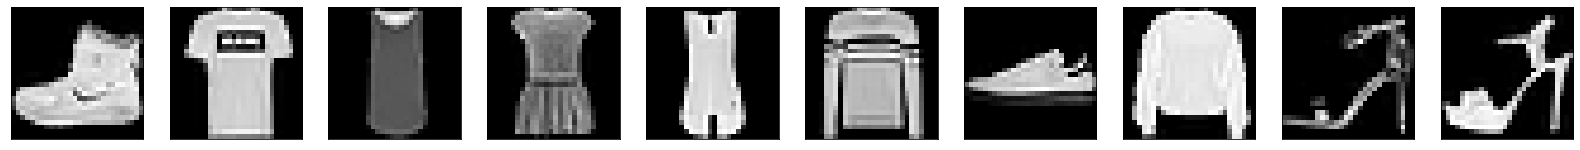

In [154]:
n = 10
plt.figure(figsize=(28, 28))
for i in range(n):
    
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [155]:
input_dim = 784
x_train = train_imgs.reshape(train_imgs.shape[0], input_dim)
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

In [163]:
optim = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [177]:
latent_dim = 256

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model  

In [178]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(1024, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [179]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28)
    plt.figure(figsize=(28, 28))
    for i in range(num_of_images):
        ax = plt.subplot(2, num_of_images, i + 1)
        plt.imshow(generated_images[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [180]:
discriminator = build_discriminator()
generator = build_generator()

discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim)

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.50it/s]


epoch:  1


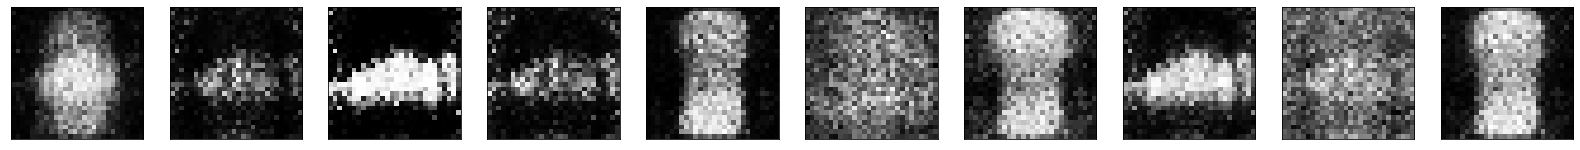

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.55it/s]


epoch:  10


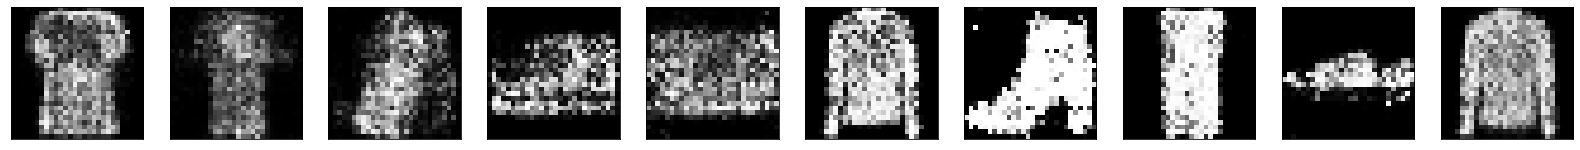

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.54it/s]


epoch:  20


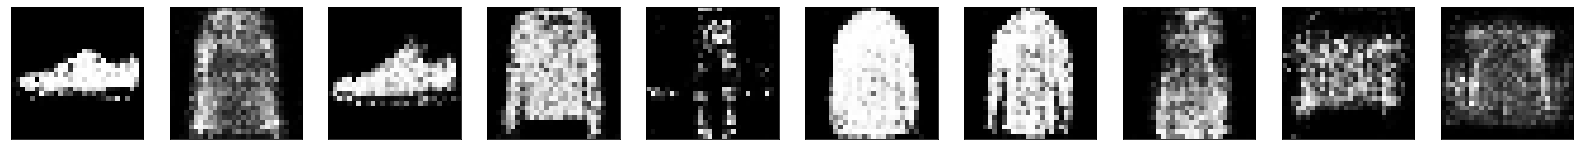

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:36<00:00,  6.36it/s]


epoch:  30


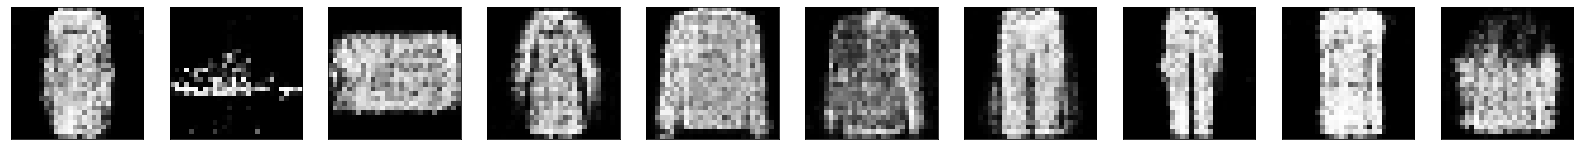

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:34<00:00,  6.71it/s]


epoch:  40


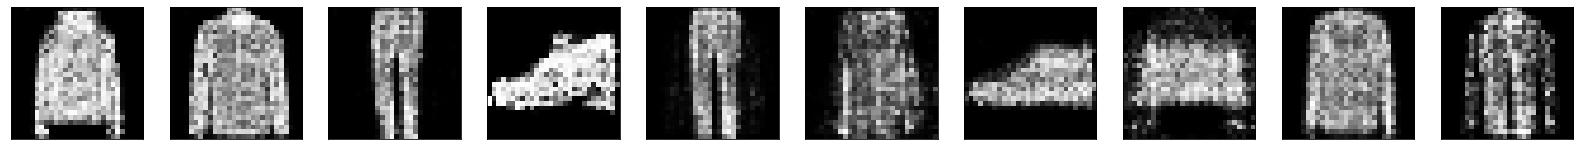

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.58it/s]


epoch:  50


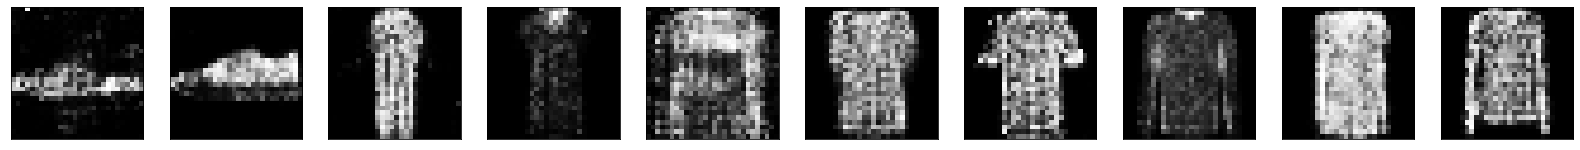

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.62it/s]


epoch:  60


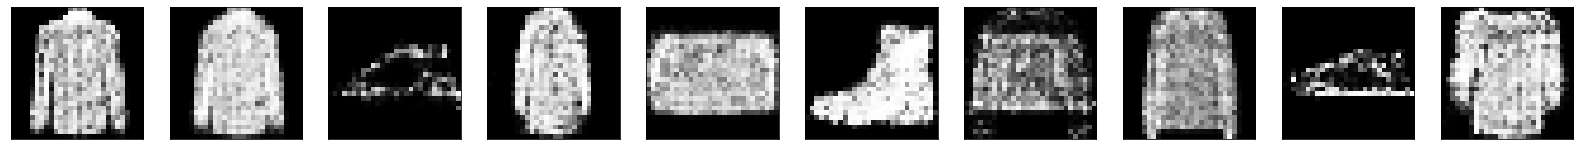

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.61it/s]


epoch:  70


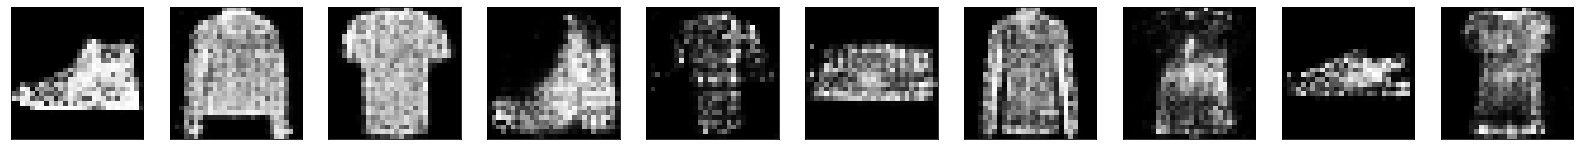

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:34<00:00,  6.71it/s]


epoch:  80


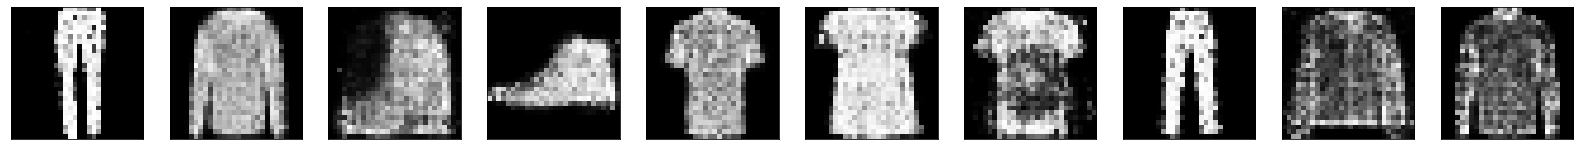

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.65it/s]


epoch:  90


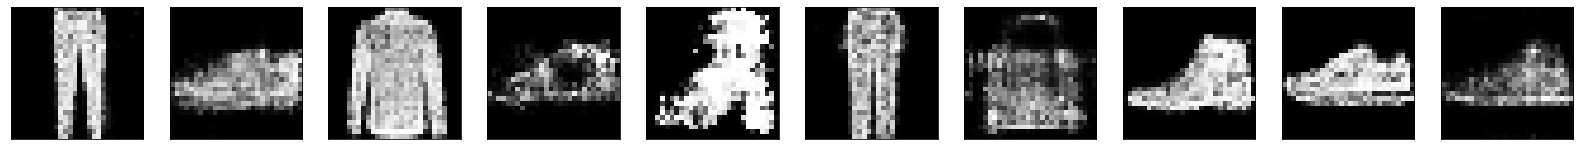

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:34<00:00,  6.72it/s]


epoch:  100


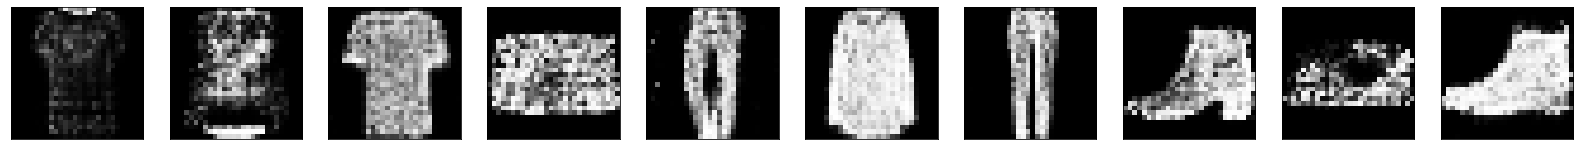

In [181]:
epochs = 100
batch_size = 256

batch_count = x_train.shape[0] // batch_size
adam = optim
for e in range(1, epochs + 1):
    for _ in tqdm(range(batch_count)):
        noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
        image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        generated_images = generator.predict(noise)
        X = np.concatenate([image_batch, generated_images])
        y_dis = np.zeros(2*batch_size)
        y_dis[:batch_size] = 0.9
        discriminator.trainable = True
        discriminator.train_on_batch(X, y_dis)
        noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        gan.train_on_batch(noise, y_gen)
    if e == 1 or e % 10 == 0:
        print('epoch: ', e)
        plot_generated_images(e, generator)